In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.Collecting xgboost
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.1 MB/s eta 0:02:14
   ---------------------------------------- 0.8/150.0 MB 1.2 MB/s eta 0:02:01
   ---------------------------------------- 1.0/150.0 MB 1.2 MB/s eta 0:02:08
   ---------------------------------------- 1.6/150.0 MB 1.3 MB/s eta 0:01:54
   ---------------------------------------- 1.8/150.0 MB 1.4 MB/s eta 0:01:46
    --------------------------------------- 2.4/150.0 MB 1.5 MB/s eta 0:01:36
    --------------------------------------- 2.9/150.0 MB 1.6 MB/s eta 0:01:31
    --------------------------------------- 3.4/150.0 MB 1.8 MB/s eta 0:01:24
   - -------------------------------------- 3.9/150.0 MB 1.9 MB/s eta 0:01:18
 

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
import xgboost as xgb

class PolyBagML:
    def __init__(self, num_trees=100, max_depth=3):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.trees = []

    def _fit_tree(self, X, y):
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrapped = X[indices]
        y_bootstrapped = y[indices]
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(X_bootstrapped, y_bootstrapped)
        return tree

    def _fit_xgboost(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        params = {
            'objective': 'reg:squarederror',
            'max_depth': self.max_depth,
            'eval_metric': 'rmse'
        }
        return xgb.train(params, dtrain, num_boost_round=self.num_trees)

    def fit(self, X, y, use_xgboost=False):
        if use_xgboost:
            self.trees = self._fit_xgboost(X, y)
        else:
            self.trees = [self._fit_tree(X, y) for _ in range(self.num_trees)]

    def predict(self, X):
        if isinstance(self.trees, list):  # Decision trees
            predictions = np.mean([tree.predict(X) for tree in self.trees], axis=0)
            return predictions
        else:  # XGBoost
            dtest = xgb.DMatrix(X)
            return self.trees.predict(dtest)

def load_and_clean_data(path):
    df = pd.read_csv(path, encoding='latin-1')
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df

def encode_features(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(lambda x: hash(x) % 100000)
    return df

def preprocess_target(y):
    le = LabelEncoder()
    return le.fit_transform(y)

def main():
    file_path = "DDoSdata(1).csv"  # Replace with actual path if needed

    df = load_and_clean_data(file_path)

    # Separate features and target
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Encode non-numeric features
    X = encode_features(X)

    # Polynomial Feature Extraction
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Encode target
    y_encoded = preprocess_target(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y_encoded, test_size=0.2, random_state=42)

    # Train and evaluate PolyBagML - Decision Tree
    print("=== PolyBagML (Decision Tree) ===")
    model_tree = PolyBagML(num_trees=100, max_depth=3)
    model_tree.fit(X_train, y_train, use_xgboost=False)
    y_pred_tree = model_tree.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred_tree))
    print("R² Score:", r2_score(y_test, y_pred_tree))

    # Train and evaluate PolyBagML - XGBoost
    print("\n=== PolyBagML (XGBoost) ===")
    model_xgb = PolyBagML(num_trees=100, max_depth=3)
    model_xgb.fit(X_train, y_train, use_xgboost=True)
    y_pred_xgb = model_xgb.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred_xgb))
    print("R² Score:", r2_score(y_test, y_pred_xgb))

if __name__ == "__main__":
    main()


=== PolyBagML (Decision Tree) ===
MSE: 1.1180992313067796e-07
R² Score: 0.999995740012771

=== PolyBagML (XGBoost) ===
MSE: 2.873413392509872e-11
R² Score: 1.0


=== PolyBagML (Decision Tree) ===
MSE: 1.5373864430468233e-07
R² Score: 0.9999941425175601

=== PolyBagML (XGBoost) ===
MSE: 2.873413392509872e-11
R² Score: 1.0


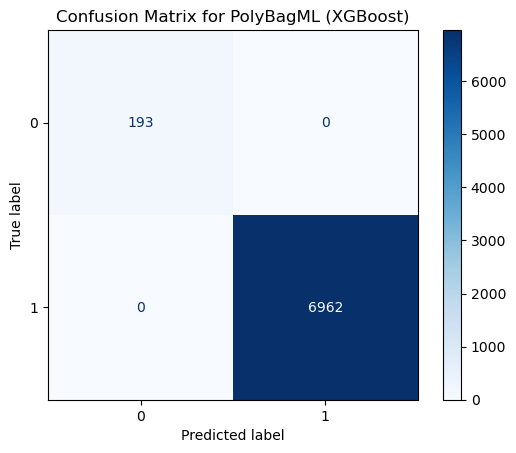

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
import xgboost as xgb

# === 1. PolyBagML Class ===
class PolyBagML:
    def __init__(self, num_trees=100, max_depth=3):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.trees = []

    def _fit_tree(self, X, y):
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrapped = X[indices]
        y_bootstrapped = y[indices]
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(X_bootstrapped, y_bootstrapped)
        return tree

    def _fit_xgboost(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        params = {
            'objective': 'reg:squarederror',
            'max_depth': self.max_depth,
            'eval_metric': 'rmse'
        }
        return xgb.train(params, dtrain, num_boost_round=self.num_trees)

    def fit(self, X, y, use_xgboost=False):
        if use_xgboost:
            self.trees = self._fit_xgboost(X, y)
        else:
            self.trees = [self._fit_tree(X, y) for _ in range(self.num_trees)]

    def predict(self, X):
        if isinstance(self.trees, list):  # Decision Trees
            predictions = np.mean([tree.predict(X) for tree in self.trees], axis=0)
            return predictions
        else:  # XGBoost
            dtest = xgb.DMatrix(X)
            return self.trees.predict(dtest)

# === 2. Utility Functions ===
def load_and_clean_data(path):
    df = pd.read_csv(path, encoding='latin-1')
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df

def encode_features(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(lambda x: hash(x) % 100000)
    return df

def preprocess_target(y):
    le = LabelEncoder()
    return le.fit_transform(y)

def plot_confusion_matrix(y_true, y_pred):
    y_pred_class = np.round(y_pred).astype(int)
    y_true_class = y_true.astype(int)
    cm = confusion_matrix(y_true_class, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix for PolyBagML (XGBoost)")
    plt.show()

# === 4. Main Function ===
def main():
    file_path = "DDoSdata(1).csv"  # Update if needed

    df = load_and_clean_data(file_path)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    X = encode_features(X)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    y_encoded = preprocess_target(y)

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y_encoded, test_size=0.2, random_state=42)

    # === Train PolyBagML - Decision Tree
    print("=== PolyBagML (Decision Tree) ===")
    model_tree = PolyBagML(num_trees=100, max_depth=3)
    model_tree.fit(X_train, y_train, use_xgboost=False)
    y_pred_tree = model_tree.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred_tree))
    print("R² Score:", r2_score(y_test, y_pred_tree))

    # === Train PolyBagML - XGBoost
    print("\n=== PolyBagML (XGBoost) ===")
    model_xgb = PolyBagML(num_trees=100, max_depth=3)
    model_xgb.fit(X_train, y_train, use_xgboost=True)
    y_pred_xgb = model_xgb.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred_xgb))
    print("R² Score:", r2_score(y_test, y_pred_xgb))

    # === Plots
    plot_confusion_matrix(y_test, y_pred_xgb)

if __name__ == "__main__":
    main()


In [43]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3
}

evals_result = {}
model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=50, 
    evals=[(dtest, 'eval')], 
    evals_result=evals_result,
    verbose_eval=False
)

# You can now extract RMSE over epochs
rmse_per_round = evals_result['eval']['rmse']


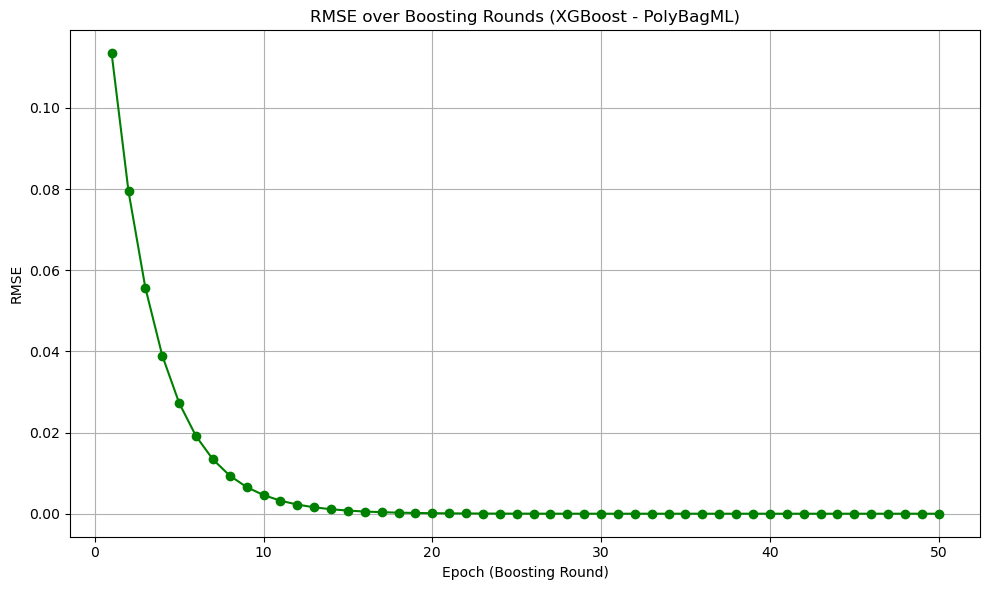

In [39]:
import matplotlib.pyplot as plt

# X-axis = Boosting rounds (epochs)
epochs = list(range(1, len(rmse_per_round) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, rmse_per_round, marker='o', color='green')
plt.title("RMSE over Boosting Rounds (XGBoost - PolyBagML)")
plt.xlabel("Epoch (Boosting Round)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Re-import everything after code execution state reset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder

# Reload the dataset
df = pd.read_csv("DDoSdata(1).csv", encoding="latin-1")

# Clean missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Feature-target split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode non-numeric features
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].apply(lambda x: hash(x) % 100000)

# Polynomial feature extraction
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_encoded, test_size=0.2, random_state=42)

# Dictionary of models to evaluate
models = {
    "Multiple Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
}

# Evaluate and store results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}

results


{'Multiple Linear Regression': {'MSE': 5.189576479682797e-11,
  'R2': 0.9999999980227579},
 'Random Forest': {'MSE': 2.7952480782669513e-08, 'R2': 0.9999989350031928},
 'K-Nearest Neighbors': {'MSE': 0.0, 'R2': 1.0},
 'Gradient Boosting': {'MSE': 1.8517600203850137e-11,
  'R2': 0.9999999992944746}}

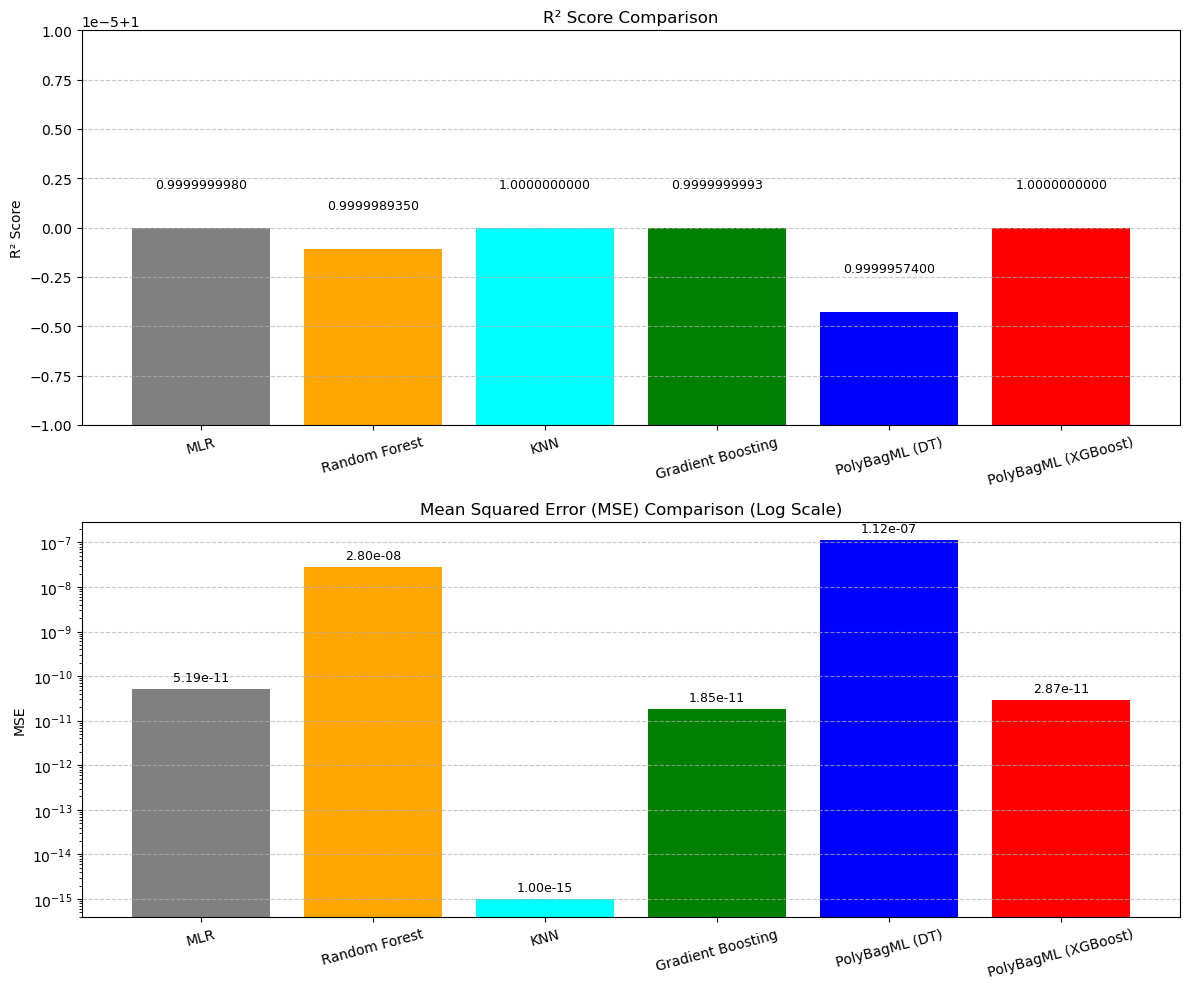

In [33]:
import matplotlib.pyplot as plt

# Model names
model_names = [
    "MLR", 
    "Random Forest", 
    "KNN", 
    "Gradient Boosting", 
    "PolyBagML (DT)", 
    "PolyBagML (XGBoost)"
]

# R² scores
r2_scores = [
    0.9999999980227579,
    0.9999989350031928,
    1.0,
    0.9999999992944746,
    0.999995740012771,
    1.0
]

# MSE values (replace 0 with a very small number to avoid log(0))
mse_values = [
    5.189576479682797e-11,
    2.7952480782669513e-08,
    1e-15,  # was 0.0 for KNN → now replaced with a small value
    1.8517600203850137e-11,
    1.1180992313067796e-07,
    2.873413392509872e-11
]

# Create the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# --- R² Plot ---
axs[0].bar(model_names, r2_scores, color=['gray', 'orange', 'cyan', 'green', 'blue', 'red'])
axs[0].set_ylim(0.99999, 1.00001)
axs[0].set_title("R² Score Comparison")
axs[0].set_ylabel("R² Score")
axs[0].grid(True, axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(r2_scores):
    axs[0].text(i, v + 0.000002, f"{v:.10f}", ha='center', fontsize=9)

# --- MSE Plot (log scale) ---
axs[1].bar(model_names, mse_values, color=['gray', 'orange', 'cyan', 'green', 'blue', 'red'])
axs[1].set_yscale('log')
axs[1].set_title("Mean Squared Error (MSE) Comparison (Log Scale)")
axs[1].set_ylabel("MSE")
axs[1].grid(True, axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(mse_values):
    axs[1].text(i, v * 1.5, f"{v:.2e}", ha='center', fontsize=9)

# Shared formatting
for ax in axs:
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=15)

plt.tight_layout()
plt.show()
